# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import copy
import pyranges as pr
import pandas as pd
import numpy as np
import scipy.stats
import pyreadr
import pyBigWig
import swifter
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, f1_score
import matplotlib.pyplot as plt
import matplotlib
from statannotations.Annotator import Annotator
from glob import glob

In [2]:
# importing the sys module
import sys        
import os
 
project_dir = os.getcwd()[:-len("notebooks/markov_models")]
sys.path.insert(0, '../..')

project_dir

'/mnt/c/Users/nicol/OneDrive/Documents/TUM/ml4regmlm/project/ML4RG-2023-project/'

In [3]:

from helpers.plots import MotifMetrics, LoadedMotifMetrics, MetricsHandler

from helpers.motifs import motifs

Matplotlib is building the font cache; this may take a moment.


In [4]:
# paths
data_dir = project_dir + "tzhdata/"
# hackish way to use the data dir on my local machine (Lukas)
if not os.path.exists(data_dir):
    data_dir = os.path.abspath("../..")

print("Data dir: ", data_dir)

Data dir:  /mnt/c/Users/nicol/OneDrive/Documents/TUM/ml4regmlm/project/ML4RG-2023-project


# Aesthetics

In [5]:
#sns.set_theme(context="poster")
sns.set_theme()
#sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_context("talk", font_scale=1.7)#, rc={"font.size": 7})
#
#sns.set_context("poster", 
sns.set_style(style={'xtick.bottom': True,'ytick.left': True, 'axes.edgecolor': 'black'})
#sns.set_style("ticks")

# Evaluation in S. cerevisiae (Fig2)

In [16]:
# define paths and names of models to evaluate
model_paths = [
    "/mnt/c/Users/nicol/OneDrive/Documents/TUM/ml4regmlm/project/ML4RG-2023-project/notebooks/markov_models/order_1_bidirectional_True_pseudocount_0/",
    "/mnt/c/Users/nicol/OneDrive/Documents/TUM/ml4regmlm/project/ML4RG-2023-project/notebooks/markov_models/order_1_bidirectional_True_pseudocount_0.01/",
    "/mnt/c/Users/nicol/OneDrive/Documents/TUM/ml4regmlm/project/ML4RG-2023-project/notebooks/markov_models/order_3_bidirectional_True_pseudocount_0/",
    "/mnt/c/Users/nicol/OneDrive/Documents/TUM/ml4regmlm/project/ML4RG-2023-project/notebooks/markov_models/order_5_bidirectional_True_pseudocount_0/",
    ]

# work around as plots.py doesn't use os.path.join to join paths...
model_names = [
    "order_1_pseudocount_0",
    "order_1_pseudocount_0.01",
    "order_3_pseudocount_0",
    "order_5_pseudocount_0",
    ]

print(model_paths)
print(model_names)

# test_set 
test_path = glob(os.path.join(data_dir ,"*.fa"))[0]
print(test_path)


['/mnt/c/Users/nicol/OneDrive/Documents/TUM/ml4regmlm/project/ML4RG-2023-project/notebooks/markov_models/order_1_bidirectional_True_pseudocount_0/', '/mnt/c/Users/nicol/OneDrive/Documents/TUM/ml4regmlm/project/ML4RG-2023-project/notebooks/markov_models/order_1_bidirectional_True_pseudocount_0.01/', '/mnt/c/Users/nicol/OneDrive/Documents/TUM/ml4regmlm/project/ML4RG-2023-project/notebooks/markov_models/order_3_bidirectional_True_pseudocount_0/', '/mnt/c/Users/nicol/OneDrive/Documents/TUM/ml4regmlm/project/ML4RG-2023-project/notebooks/markov_models/order_5_bidirectional_True_pseudocount_0/']
['order_1_pseudocount_0', 'order_1_pseudocount_0.01', 'order_3_pseudocount_0', 'order_5_pseudocount_0']
/mnt/c/Users/nicol/OneDrive/Documents/TUM/ml4regmlm/project/ML4RG-2023-project/Homo_sapiens_3prime_UTR.fa


In [18]:
import pickle
with open("../../data/exclude_motifs.pickle", "rb") as f:
    config = pickle.load(f)
# combining all metrics
print(model_paths)
scer_mh = MetricsHandler(model_paths, model_names, test_path, 
                         motifs=motifs, seq_col="3UTR",
                         existing_probas=[True, True, True, True],
                         n_random_kmers=6290,
                         optional_config=config)

['/mnt/c/Users/nicol/OneDrive/Documents/TUM/ml4regmlm/project/ML4RG-2023-project/notebooks/markov_models/order_1_bidirectional_True_pseudocount_0/', '/mnt/c/Users/nicol/OneDrive/Documents/TUM/ml4regmlm/project/ML4RG-2023-project/notebooks/markov_models/order_1_bidirectional_True_pseudocount_0.01/', '/mnt/c/Users/nicol/OneDrive/Documents/TUM/ml4regmlm/project/ML4RG-2023-project/notebooks/markov_models/order_3_bidirectional_True_pseudocount_0/', '/mnt/c/Users/nicol/OneDrive/Documents/TUM/ml4regmlm/project/ML4RG-2023-project/notebooks/markov_models/order_5_bidirectional_True_pseudocount_0/']
Adding models to df
order_1_pseudocount_0
3036871
order_1_pseudocount_0.01
3036871
order_3_pseudocount_0
3036871
order_5_pseudocount_0
3036871
Searching for motifs
True
EWSR1 GGGGG
EWSR1 GGGGG
True
FUS GGGGG
FUS GGGGG
True
TAF15 GGGGG
TAF15 GGGGG
True
HNRNPL ACACA
HNRNPL ACACA
True
PABPN1L AAAAA
PABPN1L AAAAA
True
TRA2A GAAGA
TRA2A GAAGA
True
PCBP2 CCCCC
PCBP2 CCCCC
True
RBFOX2 GCATG
RBFOX2 GCATG
True

In [21]:
scer_mh

In [22]:
# motif renaming
def motif_correction(m_name):
    return m_name +"\n"+ motifs.name_seq_dict[m_name].replace("T","U")
def fix(x):
    if x=="non_motif":
        return "non-motif"
    else:
        return motif_correction(x)

In [23]:
# adding gpar positions here

cols = ["motif_range","motif","model","avg_target_probas"]
keep_models = [
    "order_1_pseudocount_0",
    "order_1_pseudocount_0.01",
    "order_3_pseudocount_0",
    "order_5_pseudocount_0"
    ]

scer_df_gpar = scer_mh.motif_df_l[scer_mh.motif_df_l["model"].isin(keep_models)]

#scer_test_path_gpar = data_dir + "gpar_clip_jun.csv"

#scer_mh_gpar = MetricsHandler(model_paths, _names, scer_test_path_gpar, motifs=motifs, seq_col="UTR3_seq",
                         #binding_site_col="gpar_binding", random_kmer_len=7, n_random_kmers=6290, existing_probas=[False, False,True, False,False,])

#gpar_plot_df = scer_mh_gpar.motif_df_l
#gpar_plot_df = gpar_plot_df[gpar_plot_df.motif.isin(["non_motif","gpar_binding"])]
#gpar_plot_df = gpar_plot_df[gpar_plot_df.target_probas.apply(lambda x: len(x)>0)]

#gpar_plot_df = gpar_plot_df.query("motif=='gpar_binding' and model in @keep_models")
gpar_plot_df = scer_df_gpar.loc[scer_df_gpar['motif_range'].apply(lambda x: x[1] - x[0] > 20 and x[1] - x[0] < 30)]

plot_df = scer_df_gpar.query("model in @keep_models")[cols]
plot_df = plot_df.rename(columns={"model":"Model"})


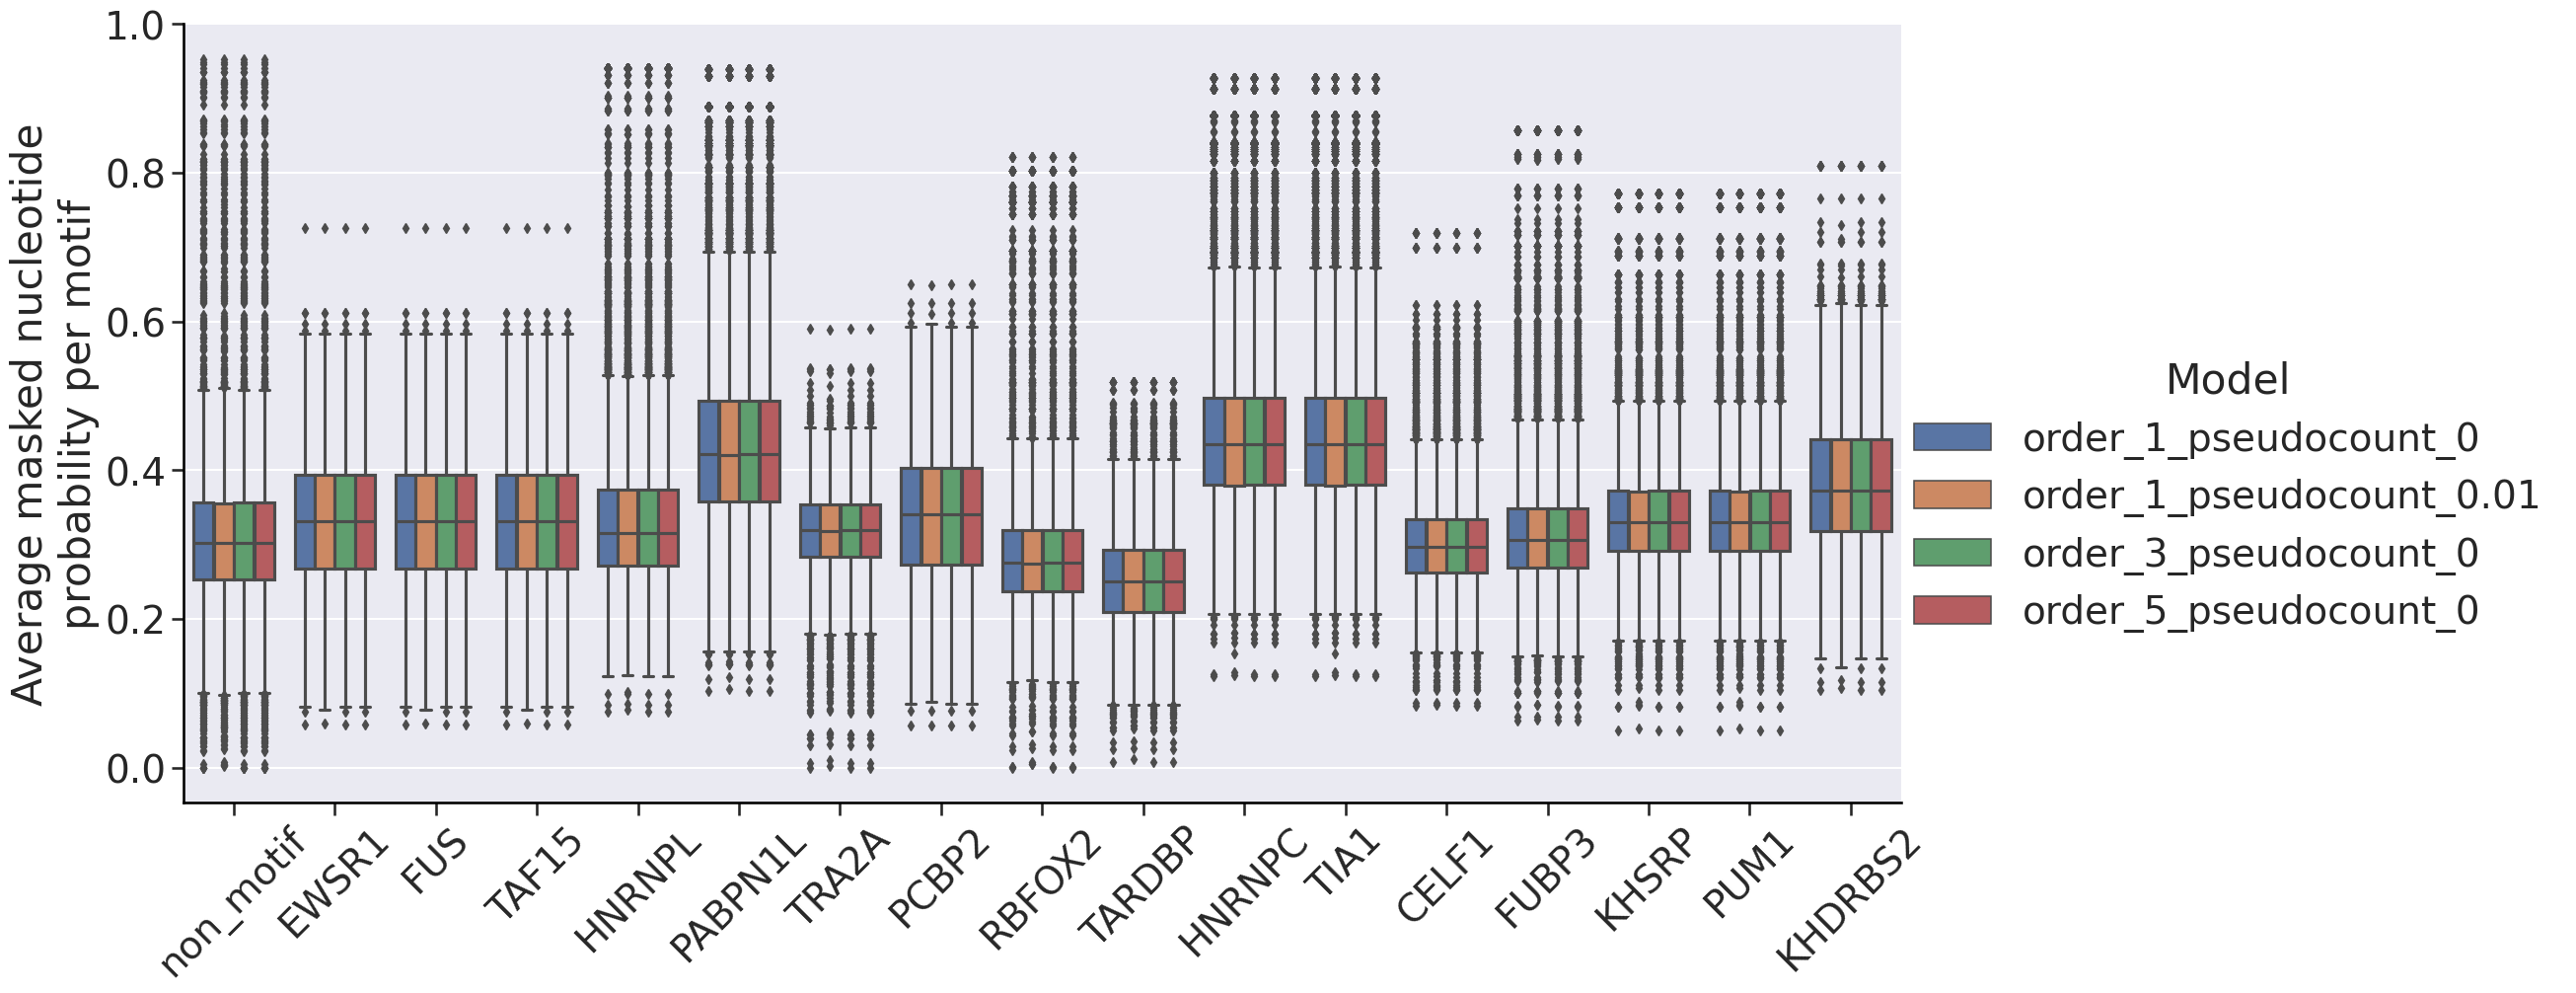

In [24]:
# plot

plot_significance = False

order = list(plot_df["motif"].unique())
labels = order
mots = order

# mods = [#("Dinucleotide distribution", "Species-agnostic"),
#         #("Species-agnostic","Species-aware"),
#         ("Dinucleotide distribution", "Species-aware"),
#         #("11-mer", "Species-agnostic"),
#         ("11-mer","Species-aware"),
#         ("Dinucleotide distribution", "11-mer"),
#         #("DNABERT", "Species-agnostic"),
#         #("DNABERT","Species-aware"),
#         #("Dinucleotide distribution", "DNABERT"),
#         #("11-mer", "DNABERT")
#         ]


g = sns.catplot(data=plot_df, x="motif", y="avg_target_probas", hue="Model",kind="box", height=10, aspect=2.0,
           order=order, estimator=np.mean)#, palette=custom_colors)

plt.xticks(ticks = range(0,len(order)),labels=labels, rotation=45)
#plt.yticks(ticks=[0.2,0.4,0.6,0.8,1.0])

if plot_significance:
    pairs=[]

    for m in mots:
        for mod in mods:
            pairs.append(((m,mod[0]),(m,mod[1])))

    for ax_n in g.axes:
        for ax in ax_n:
            # do I need to subset the data?
            annotator = Annotator(ax, pairs, data=plot_df, x="motif", y="avg_target_probas", hue="Model")
            #    order=order)
            annotator.configure(test='Wilcoxon', text_format='star', loc='inside', comparisons_correction="BH")
            annotator.apply_and_annotate()



plt.xlabel("")
plt.ylabel("Average masked nucleotide\nprobability per motif")
plt.show()

('Species-aware', 'non_motif')
----------------
('Species-aware', 'EWSR1')
('Species-aware', 'non_motif')
----------------
('Species-aware', 'FUS')
('Species-aware', 'non_motif')
----------------
('Species-aware', 'TAF15')
('Species-aware', 'non_motif')
----------------
('Species-aware', 'HNRNPL')
('Species-aware', 'non_motif')
----------------
('Species-aware', 'PABPN1L')
('Species-aware', 'non_motif')
----------------
('Species-aware', 'TRA2A')
('Species-aware', 'non_motif')
----------------
('Species-aware', 'PCBP2')
('Species-aware', 'non_motif')
----------------
('Species-aware', 'RBFOX2')
('Species-aware', 'non_motif')
----------------
('Species-aware', 'TARDBP')
('Species-aware', 'non_motif')
----------------
('Species-aware', 'HNRNPC')
('Species-aware', 'non_motif')
----------------
('Species-aware', 'TIA1')
('Species-aware', 'non_motif')
----------------
('Species-aware', 'PTBP3')
('Species-aware', 'non_motif')
----------------
('Species-aware', 'CELF1')
('Species-aware', 'non

<Figure size 640x480 with 0 Axes>

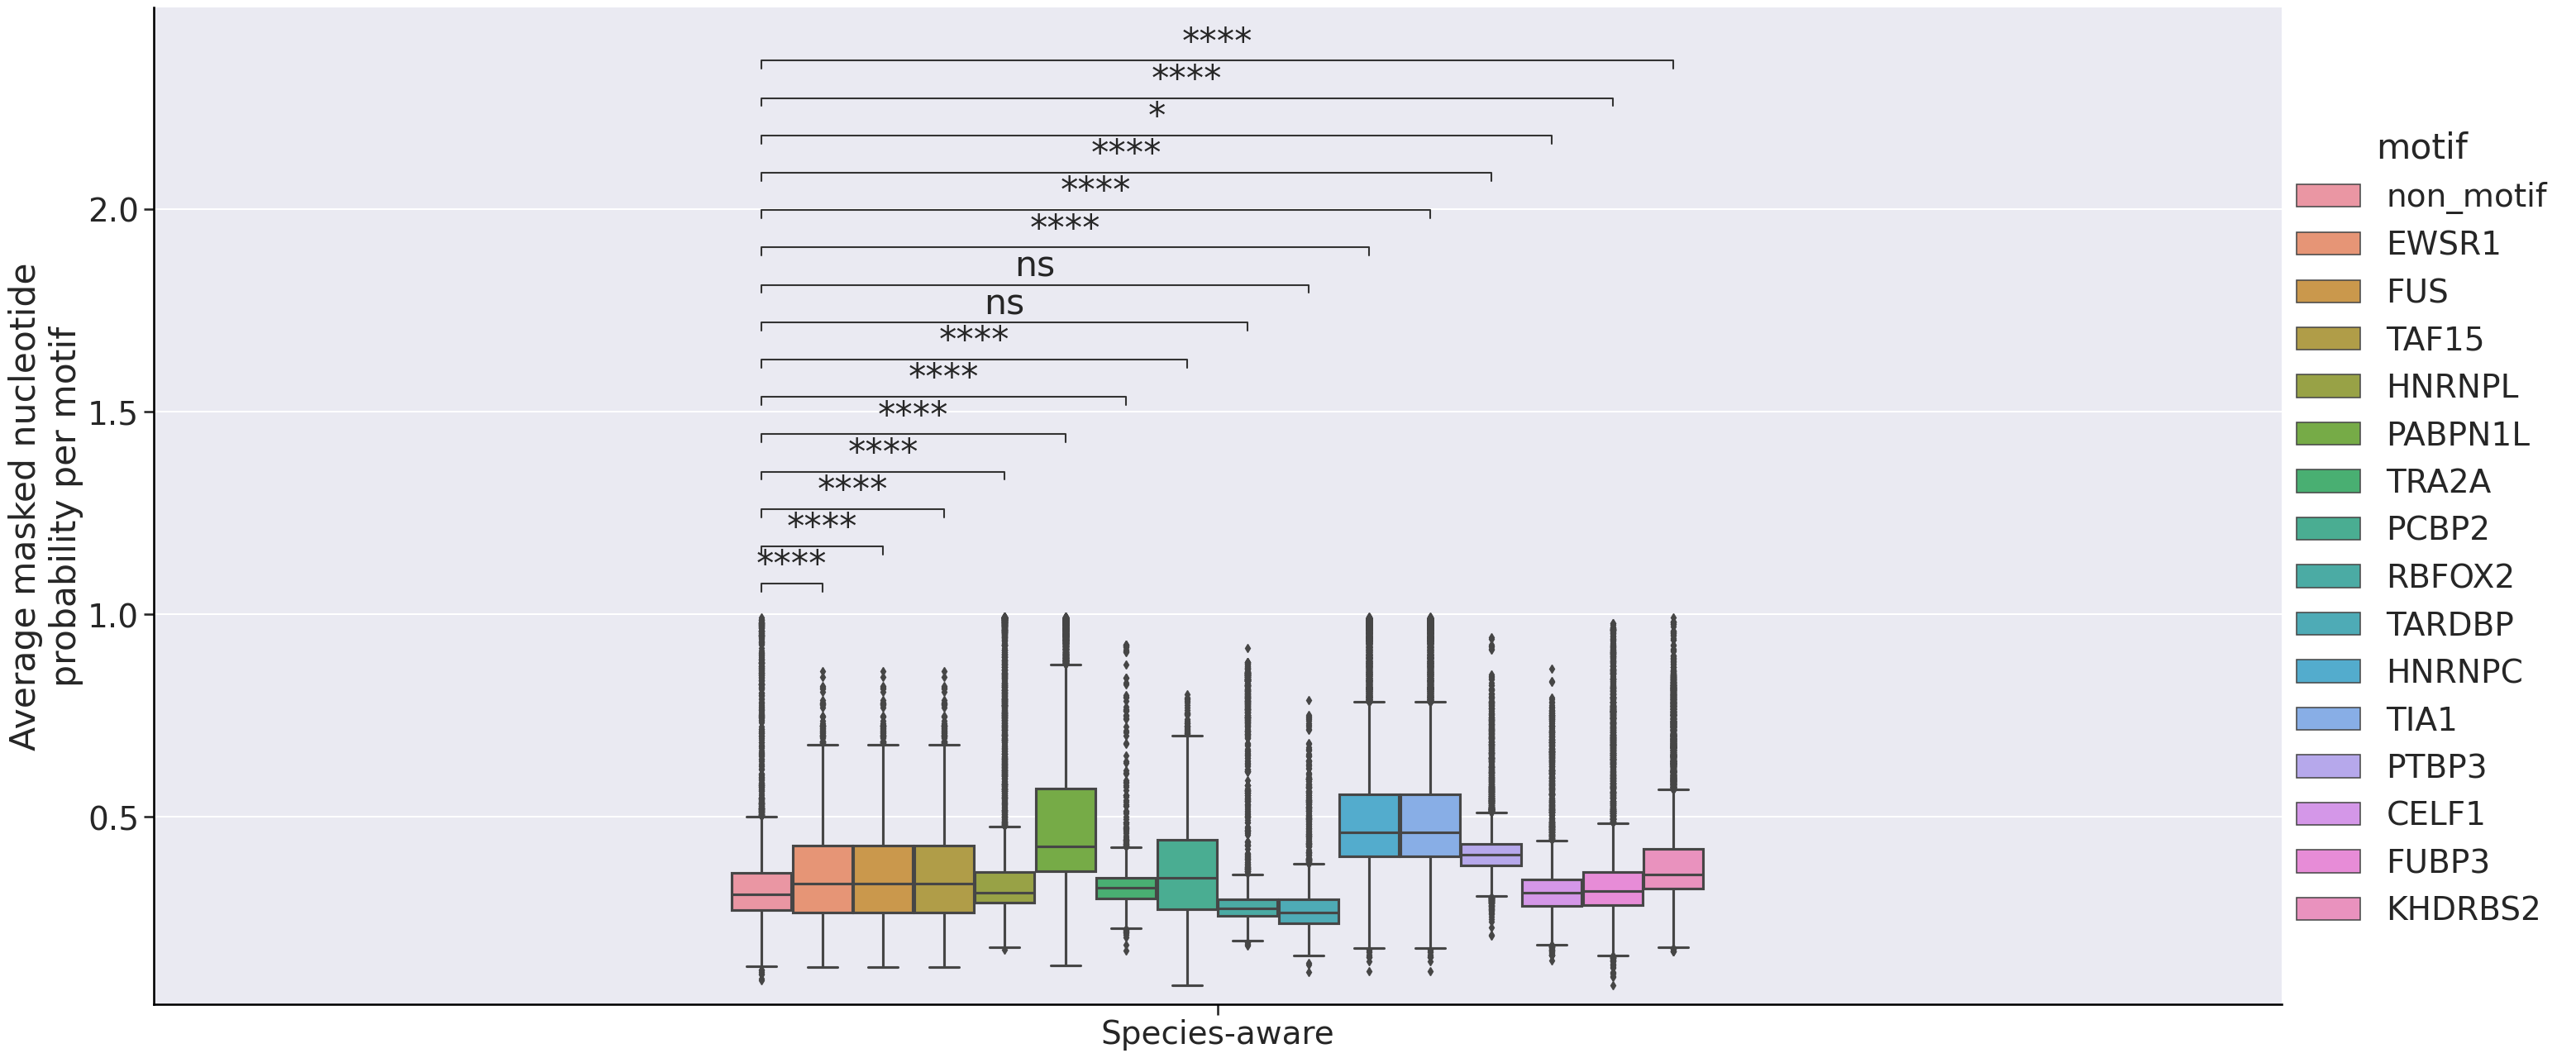

In [ ]:
# plot
plt.clf()
plot_significance = True

#order = list(plot_df["motif"].unique())
order = ["Species-aware"]

labels = order
mots = order

motifs = list(plot_df["motif"].unique())

mods = [("non_motif", motif) for motif in motifs]

mods_tmp = []
for m1, m2 in mods:
    if m1 != m2:
        mods_tmp.append((m1,m2))

mods = mods_tmp
    

g = sns.catplot(data=plot_df, x="Model", y="avg_target_probas", hue="motif",kind="box", height=14, aspect=2.0,
           order=order, estimator=np.mean)#, palette=custom_colors)

#plt.xticks(ticks = range(0,len(order)),labels=labels)
#plt.yticks(ticks=[0.2,0.4,0.6,0.8,1.0])

if plot_significance:
    #pairs=mods
    
    pairs = [(("Species-aware", motif1), ("Species-aware", motif2)) for motif1, motif2 in mods]
    # for m in mots:
    #     for mod in mods:
    #         pairs.append(((m,mod[0]),(m,mod[1])))
    for ax_n in g.axes:
        for ax in ax_n:
            # do I need to subset the data?
            annotator = Annotator(ax, pairs, data=plot_df, x="Model", y="avg_target_probas", hue="motif", order=order)
            annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='inside', comparisons_correction="BH")
            annotator.apply_and_annotate()



plt.xlabel("")
plt.ylabel("Average masked nucleotide\nprobability per motif")
plt.show()

# Puf3 evolution (Fig3)

In [ ]:
# define paths and names 

crassa_paths = [
    results_dir + "cglabrata_label_in_ncrassa/",
    results_dir + "species_aware_in_ncrassa/",
]

crassa_names= [
    "S.cer proxy label",
    "N.crassa label",]

# path to the CSV 
crassa_test_path = data_dir + "neurospora_crassa_transcripts_600_upstream_300_downstream.csv"

scer_paths = [
    results_dir + "ncrassa_label_in_scer/",
    results_dir + "species_aware_in_scer/"
]
model_names = [
    "N.crassa label",
    "S.cer proxy label",
    ]

test_data_path = data_dir + "Scer_half_life.csv"


In [ ]:
%%capture
crassa_mh = MetricsHandler(crassa_paths, crassa_names, crassa_test_path, motifs=pufm,  seq_col="three_prime_region") 
scer_mh_puf = MetricsHandler(scer_paths, scer_names, scer_test_path, motifs=pufm, seq_col="UTR3_seq") 

In [ ]:
keep = ["N.crassa label", "S.cer proxy label"]
scer_df = scer_mh_puf.motif_df_l[scer_mh_puf.motif_df_l["model"].isin(keep)]

scer_df["Cross Entropy"] = scer_df["cross_entropy"]
scer_df["Log-Likelihood"] = scer_df["avg_ll"]
scer_df["Masked Nucleotide Probability"] = scer_df["avg_target_probas"]
scer_df["Model"] = scer_df["model"]

crassa_df = crassa_mh.motif_df_l[crassa_mh.motif_df_l["model"].isin(keep)]

crassa_df["Cross Entropy"] = crassa_df["cross_entropy"]
crassa_df["Log-Likelihood"] = crassa_df["avg_ll"]
crassa_df["Masked Nucleotide Probability"] = crassa_df["avg_target_probas"]
crassa_df["Model"] = crassa_df["model"]

In [ ]:
# get probability at specific position 
def get_middle_letter(row):
    if row.motif in (["Puf3","Puf3_T","Puf3_C"]):
        return float(row.target_probas[4])
    else:
        return -100

scer_df["target_proba_puf"] = scer_df.swifter.apply(lambda row: get_middle_letter(row), axis=1) 
crassa_df["target_proba_puf"] = crassa_df.swifter.apply(lambda row: get_middle_letter(row), axis=1)  

Pandas Apply:   0%|          | 0/8268 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4632 [00:00<?, ?it/s]

In [ ]:
# concatenate dfs
puf3_df = pd.concat([crassa_df,scer_df],axis=0)
assert len(puf3_df) == len(crassa_df) + len(scer_df)
puf3_df["Test species"] = (["N.crassa"]  * len(crassa_df)) + ["S.cerevisiae"] * len(scer_df)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Puf3_C_S.cer proxy label vs. Puf3_C_N.crassa label: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.231e-47 Stat=1.158e+03
Puf3_S.cer proxy label vs. Puf3_N.crassa label: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:7.603e-47 Stat=3.600e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Puf3_C_S.cer proxy label vs. Puf3_C_N.crassa label: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.231e-47 Stat=1.158e+03
Puf3_S.cer proxy label vs. Puf3_N.crassa label: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:7.603e-47 Stat=3.600e+01


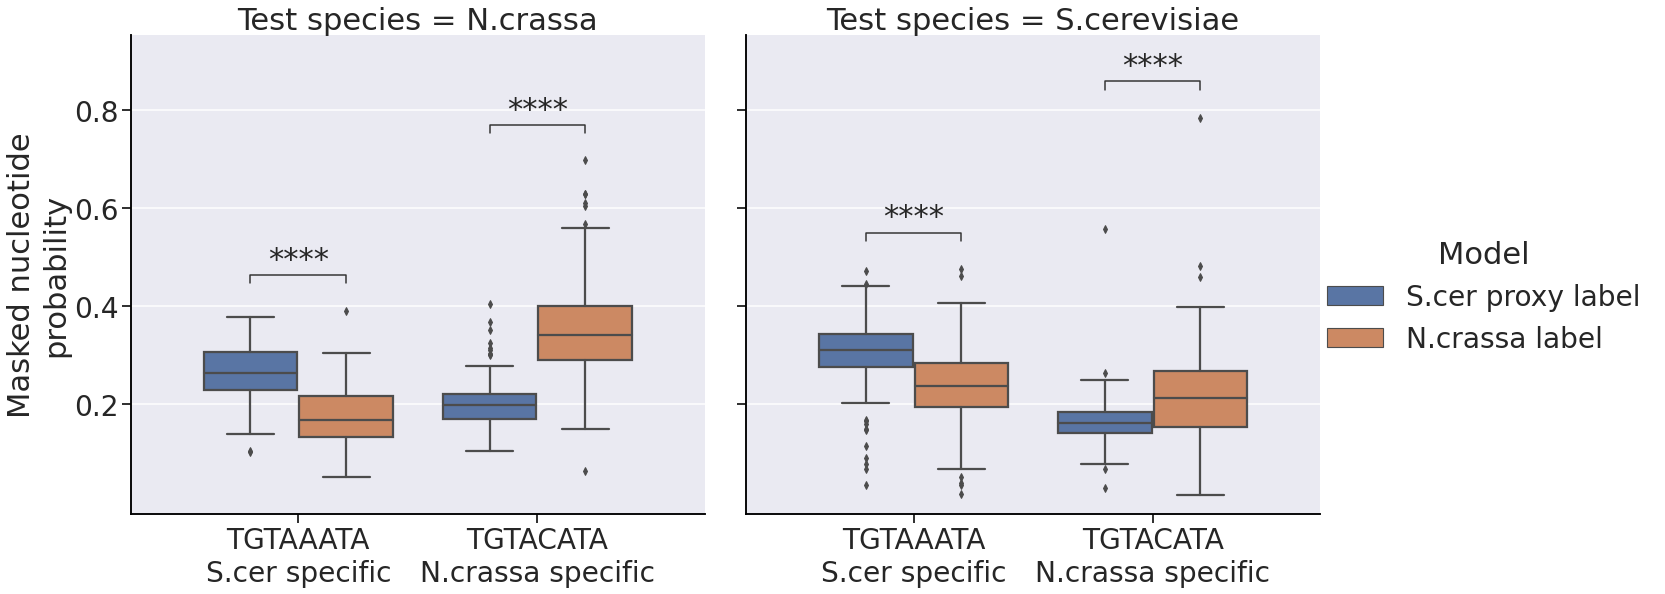

In [ ]:
g = sns.catplot(data=puf3_df, x="motif", y="target_proba_puf", hue="Model",kind="box", height=9, aspect=1.05, 
                order=["Puf3", "Puf3_C"], hue_order=["S.cer proxy label","N.crassa label" ],
                col="Test species")
    
g.set_axis_labels("", "Masked nucleotide\nprobability")
g.set_xticklabels(['TGTAAATA\nS.cer specific',
            'TGTACATA\nN.crassa specific'])

plt.yticks(ticks=[0.2,0.4,0.6,0.8,1.0])

mots = ["Puf3", "Puf3_C"]
mods = [("S.cer proxy label", "N.crassa label"),]

pairs=[]

for m in mots:
    for mod in mods:
        pairs.append(((m,mod[0]),(m,mod[1])))


for ax_n in g.axes:
    for ax,df_ in zip(ax_n,[crassa_df,scer_df]):
        # do I need to subset the data?
        annotator = Annotator(ax, pairs, data=puf3_df[puf3_df.model!="SSM"], x="motif", y="target_proba_puf", hue="Model",
            order=["Puf3", "Puf3_C"])
        annotator.configure(test='Wilcoxon', text_format='star', loc='inside', comparisons_correction="BH")
        annotator.apply_and_annotate()

# GPAR "zero-shot"

In [ ]:
scer_paths = [
    results_dir + "conservation/",
    results_dir + "dna_bert/cheng_bertadn/",
    results_dir + "species_agnostic/",
    results_dir + "species_aware_in_scer/",
]

# how to name the models (same order as above)
model_names= [
    "Conservation",
    "DNABERT",
    "Species-agnostic", 
    "Species-aware"]

existing_probas = [True, True, False, False]

In [ ]:
gpar_zero_shot_output_path = results_dir + "gpar_species_aware/"
gpar_zero_shot_baseline_output_path = results_dir + "gpar_species_agnostic/"
gpar_zero_shot_bertadn_output_path = results_dir + "dna_bert/gpar_bertadn/"
gpar_zero_shot_df_path = data_dir + "gpar_clip_downstream.csv"

In [ ]:
def get_roc(df, score_col, model, label_col="original", label_pos=None):
    df = df.query('model == @model')
    scores= np.array(df[score_col])
    if not label_pos:
        labels=np.array(df[label_col])
    else:
        labels=np.array(df[label_col] == label_pos)
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = roc_auc_score(labels, scores)
    auc_var = delong_roc_variance(ground_truth=labels, 
                                   predictions = scores)[1]
    auprc = average_precision_score(labels, scores)
    return fpr, tpr, roc_curve, roc_auc, auprc, auc_var

def get_roc_from_merged(df, score_col ,label_col="original", label_pos=None):
    scores = np.array(df[score_col])
    if not label_pos:
        labels=np.array(df[label_col])
    else:
        labels=np.array(df[label_col] == label_pos)
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = roc_auc_score(labels, scores)
    return fpr, tpr, roc_curve, roc_auc

def compare_pval(df, score_col, model1, model2, label_col="original", id_cols=['binding_range_str'],
                label_pos=None):
    df_model1 = df.query('model == @model1')[id_cols + [score_col, label_col]].rename(columns={score_col:score_col+"_"+model1})
    df_model2 = df.query('model == @model2')[id_cols + [score_col, label_col]].rename(columns={score_col:score_col+"_"+model2})
    assert len(df_model2) == len(df_model1)
    merged = df_model1.merge(df_model2, on=id_cols + [label_col])
    assert len(merged) == len(df_model1)
    if not label_pos:
        labels = merged[label_col]
    else:
        labels = merged[label_col] == label_pos
    return delong_roc_test(ground_truth=labels, 
                           predictions_one = merged[score_col+"_"+model1], 
                           predictions_two = merged[score_col+"_"+model2])

In [ ]:
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=float)
    ty = np.empty([k, n], dtype=float)
    tz = np.empty([k, m + n], dtype=float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (~ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

### Binding v. Nonbinding

In [ ]:
%%capture

keep_models = ["Conservation","Species-agnostic", "Species-aware", "DNABERT"]

scer_test_path_gpar = data_dir + "gpar_clip_jun.csv"

scer_mh_gpar = MetricsHandler(scer_paths, scer_names, scer_test_path_gpar, motifs=pufm, seq_col="UTR3_seq",
                         binding_site_col="gpar_binding", random_kmer_len=20, n_random_kmers=5000*2, existing_probas=existing_probas)

gpar_plot_df = scer_mh_gpar.motif_df_l
gpar_plot_df = gpar_plot_df[gpar_plot_df.motif.isin(["non_motif","gpar_binding"])]
gpar_plot_df = gpar_plot_df[gpar_plot_df.target_probas.apply(lambda x: len(x)>0)]

gpar_plot_df = gpar_plot_df.query("model in @keep_models")
gpar_plot_df = (gpar_plot_df
                .loc[gpar_plot_df['motif_range'].apply(lambda x: x[1] - x[0] > 20 and x[1] - x[0] < 30)
                     | gpar_plot_df.motif.apply(lambda x: x == "non_motif")])
gpar_plot_df["binding_range_str"] = gpar_plot_df["motif_range"].astype('str')
#plot_df = plot_df.rename(columns={"model":"Model"})
gpar_plot_df = gpar_plot_df.drop_duplicates(subset=['motif','model','avg_target_probas', 'binding_range_str'])

In [ ]:
10**compare_pval(gpar_plot_df, score_col="avg_target_probas", model1="Species-agnostic", model2="Species-aware",
             label_col="motif",label_pos="gpar_binding")

array([[4.54849403e-16]])

In [ ]:
fpr_con, tpr_con, roc_curve_con, roc_auc_con, auprc_con, var_con = get_roc(gpar_plot_df, "avg_target_probas", "Conservation", label_col="motif",label_pos="gpar_binding")
fpr_bert, tpr_bert, roc_curve_bert, roc_auc_bert, auprc_bert, var_bert = get_roc(gpar_plot_df, "avg_target_probas", "DNABERT", label_col="motif",label_pos="gpar_binding")
fpr_ssm, tpr_ssm, roc_curve_ssm, roc_auc_ssm, auprc_ssm, var_ssm = get_roc(gpar_plot_df, "avg_target_probas", "Species-agnostic", label_col="motif",label_pos="gpar_binding")
fpr_spec, tpr_spec, roc_curve_spec, roc_auc_spec, auprc_spec, var_spec = get_roc(gpar_plot_df, "avg_target_probas", "Species-aware", label_col="motif",label_pos="gpar_binding")

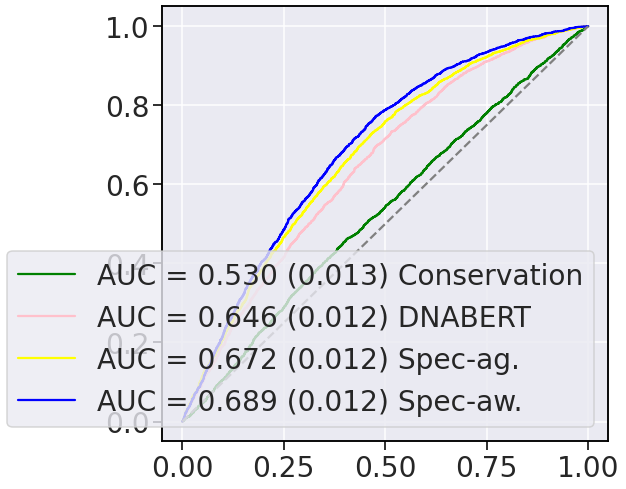

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr_con,tpr_con, color="green", label="AUC = {:2.3f} ({:2.3f}) Conservation".format(roc_auc_con, 2*np.sqrt(var_con)))
ax.plot(fpr_bert,tpr_bert, color="pink", label="AUC = {:2.3f} ({:2.3f}) DNABERT".format(roc_auc_bert, 2*np.sqrt(var_bert)))
ax.plot(fpr_ssm,tpr_ssm, color="yellow", label="AUC = {:2.3f} ({:2.3f}) Spec-ag.".format(roc_auc_ssm, 2*np.sqrt(var_ssm)))
ax.plot(fpr_spec,tpr_spec, color="blue", label="AUC = {:2.3f} ({:2.3f}) Spec-aw.".format(roc_auc_spec, 2*np.sqrt(var_spec)))
# add diagonal
ax.plot([0,1],[0,1], color='grey', linestyle='dashed')
ax.legend(loc=4)

### Binding v. Dinucleotide shuffled

In [ ]:
%%capture
gpar_paths = [gpar_zero_shot_baseline_output_path, gpar_zero_shot_output_path, gpar_zero_shot_bertadn_output_path]
gpar_names = ["Species-agnostic", "Species-aware", "DNABERT"]

# creating metrics handlers with different motifs
scer_gpar_zero = MetricsHandler(gpar_paths, 
                                gpar_names, 
                                gpar_zero_shot_df_path, 
                                motifs=pufm, seq_col="sequence",
                                binding_site_col="gpar_binding",
                                random_kmer_len=20, n_random_kmers=5, existing_probas=[False,False, True])


In [ ]:
gpar_zero_result = scer_gpar_zero.motif_df_l.query('motif == "gpar_binding"')
gpar_zero_result["binding_range_str"] = gpar_zero_result["motif_range"].apply(lambda x: str((x[0],x[1])))
gpar_zero_shot_df = pd.read_csv(gpar_zero_shot_df_path)

/scratch/tmp/gankin/ipykernel_2070937/33279529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpar_zero_result["binding_range_str"] = gpar_zero_result["motif_range"].apply(lambda x: str((x[0],x[1])))


In [ ]:
gpar_zero_result = gpar_zero_shot_df.rename(columns={"gpar_binding":"binding_range_str"})[["gene","original","binding_range_str"]].merge(gpar_zero_result, on="binding_range_str")

In [ ]:
gpar_zero_result["averages"] = gpar_zero_result.groupby(['gene','model'])['avg_target_probas'].transform('mean')
gpar_zero_result["deviation"] = gpar_zero_result["avg_target_probas"] - gpar_zero_result["averages"]

In [ ]:
fpr_ssm, tpr_ssm, roc_curve_ssm, roc_auc_ssm, auprc_ssm, var_ssm = get_roc(gpar_zero_result, "avg_target_probas", "Species-agnostic", label_col="original")
fpr_spec, tpr_spec, roc_curve_spec, roc_auc_spec, auprc_spec, var_spec = get_roc(gpar_zero_result, "avg_target_probas", "Species-aware", label_col="original")
fpr_bert, tpr_bert, roc_curve_bert, roc_auc_bert, auprc_bert, var_bert = get_roc(gpar_zero_result, "avg_target_probas", "DNABERT", label_col="original")

In [ ]:
10**compare_pval(gpar_zero_result, score_col="avg_target_probas", model1="Species-agnostic", model2="Species-aware")

array([[2.05180419e-07]])

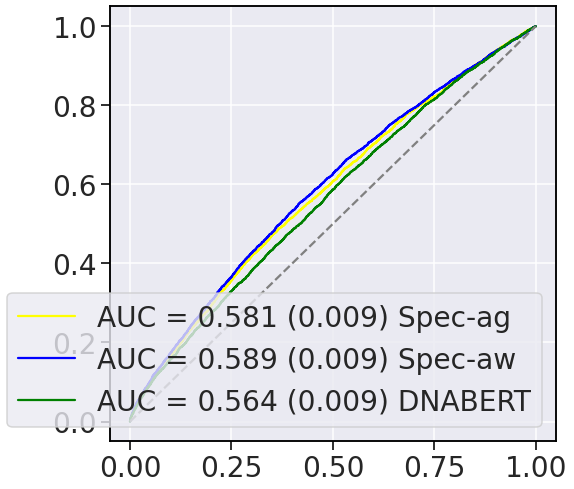

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr_ssm,tpr_ssm, color="yellow", label="AUC = {:2.3f} ({:2.3f}) Spec-ag".format(roc_auc_ssm,2*np.sqrt(var_ssm)))
ax.plot(fpr_spec,tpr_spec, color="blue", label="AUC = {:2.3f} ({:2.3f}) Spec-aw".format(roc_auc_spec,2*np.sqrt(var_spec)))
ax.plot(fpr_bert,tpr_bert, color="green", label="AUC = {:2.3f} ({:2.3f}) DNABERT".format(roc_auc_bert,2*np.sqrt(var_bert)))
# add diagonal
ax.plot([0,1],[0,1], color='grey', linestyle='dashed')
ax.legend(loc=4)

## PUF3 Zero Shot

In [ ]:
%%capture

scer_paths = [
    results_dir + "conservation/",
    results_dir + "dna_bert/cheng_bertadn/",
    results_dir + "species_agnostic/",
    results_dir + "species_aware_in_scer/",
]

# how to name the models (same order as above)
scer_names= [
    "Conservation",
    "DNABERT",
    "Species-agnostic", 
    "Species-aware"]


scer_test_path_puf =  data_dir + "Scer_half_life.csv" # with binding sites
# creating metrics handlers with different motifs
scer_mh_puf = MetricsHandler(scer_paths, scer_names, scer_test_path_puf, motifs=pufm, seq_col="UTR3_seq", existing_probas=existing_probas) 

In [ ]:
# first df with ranges
puf_df = scer_mh_puf.df
puf_df["Start"] = puf_df.seq_range.apply(lambda x: x[0])
puf_df["End"] = puf_df.seq_range.apply(lambda x: x[1])
puf_df["Chromosome"] = "chr_xxx"
puf_df_pr = pr.PyRanges(puf_df)

# motif df with motif instances
puf_df_l=scer_mh_puf.motif_df_l
puf_df_l["Start"] = puf_df_l.motif_range.apply(lambda x: x[0])
puf_df_l["End"] = puf_df_l.motif_range.apply(lambda x: x[1])
puf_df_l["Chromosome"] = "chr_xxx"
puf_dfl = puf_df_l[puf_df_l["motif"].isin(["Puf3_T","Puf3","Puf3_C","Puf3_G" ])]
puf_dfl_pr = pr.PyRanges(puf_dfl)

# join them
joined = puf_df_pr.join(puf_dfl_pr).df
joined["binding_site"] = ~joined['CLIP Class'].isna() # CLIP indicates if we have a binding site

In [ ]:
jdf = joined[joined.model.isin(["Species-agnostic","Species-aware","Conservation","DNABERT"])]
jdf = jdf[jdf.motif=="Puf3"]

In [ ]:
fpr_con, tpr_con, roc_curve_con, roc_auc_con, auprc_con, var_con = get_roc(jdf, "avg_target_probas", "Conservation", label_col="binding_site")
fpr_bert, tpr_bert, roc_curve_bert, roc_auc_bert, auprc_bert, var_bert = get_roc(jdf, "avg_target_probas", "DNABERT", label_col="binding_site")
fpr_ssm, tpr_ssm, roc_curve_ssm, roc_auc_ssm, auprc_ssm, var_ssm = get_roc(jdf, "avg_target_probas", "Species-agnostic", label_col="binding_site")
fpr_spec, tpr_spec, roc_curve_spec, roc_auc_spec, auprc_spec, var_spec = get_roc(jdf, "avg_target_probas", "Species-aware", label_col="binding_site")

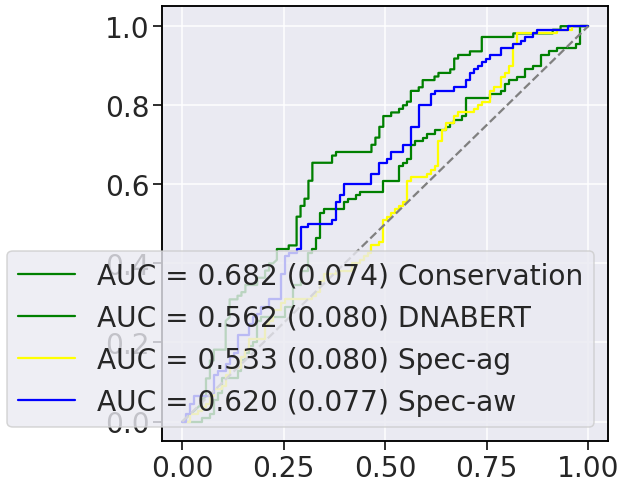

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr_con,tpr_con, color="green", label="AUC = {:2.3f} ({:2.3f}) Conservation".format(roc_auc_con, 2*np.sqrt(var_con)))
ax.plot(fpr_bert,tpr_bert, color="green", label="AUC = {:2.3f} ({:2.3f}) DNABERT".format(roc_auc_bert, 2*np.sqrt(var_bert)))
ax.plot(fpr_ssm,tpr_ssm, color="yellow", label="AUC = {:2.3f} ({:2.3f}) Spec-ag".format(roc_auc_ssm, 2*np.sqrt(var_ssm)))
ax.plot(fpr_spec,tpr_spec, color="blue", label="AUC = {:2.3f} ({:2.3f}) Spec-aw".format(roc_auc_spec, 2*np.sqrt(var_spec)))
# add diagonal
ax.plot([0,1],[0,1], color='grey', linestyle='dashed')
ax.legend(loc=4)

In [ ]:
10**compare_pval(jdf, score_col="avg_target_probas", model1="Conservation",model2="Species-aware",
                        label_col="binding_site", id_cols=['Gene','Start_b','End_b'])

array([[0.22115528]])

In [ ]:
10**compare_pval(jdf, score_col="avg_target_probas", model1="Species-agnostic", model2="Species-aware",
                        label_col="binding_site", id_cols=['Gene','Start_b','End_b'])

array([[0.00526132]])

In [ ]:
10**compare_pval(jdf, score_col="avg_target_probas", model1="DNABERT", model2="Species-aware",
                        label_col="binding_site", id_cols=['Gene','Start_b','End_b'])

array([[0.16935241]])